# Building a CLIP Inspired Multi-Modal Model

Submitted by: Rishabh Kaushick

# 1. Environment Setup (5%)

In [5]:
%pip install --quiet torch torchvision transformers datasets matplotlib tqdm pillow

Note: you may need to restart the kernel to use updated packages.


In [6]:
%reset

In [20]:
from datasets import load_dataset, load_from_disk

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests

import torch

## Setting up GPU

In [8]:
 
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")
 
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"cuDNN version: {torch.backends.cudnn.version()}")
    print(f"cuDNN enabled: {torch.backends.cudnn.enabled}")
    print(f"GPU Count: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1024**2:.2f} MB")
        print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1024**2:.2f} MB")
 
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.6.0
Is CUDA available: False
CUDA is not available. Running on CPU.


# 2. Dataset Selection and Exploration (10%)

For this assignment, I have decided to use the Flickr30k dataset. The reasons for this are as follows:
1.	The Flickr30k dataset contains much lesser images as compared to the COCO dataset. This will be easier to train due to the GPU limitations.
2.	The Flickr30k dataset contains high quality natural language captions. The COCO dataset has complex captions which could introduce more variability making the training process more difficult.
3.	Flickr30k dataset is suited for retrieval-based tasks.


## Save & Load Dataset

In [ ]:
# Load the Flickr30k dataset from Hugging Face
dataset = load_dataset("nlphuji/flickr30k", split="test[:10000]")

# looks like the main train split is called test

I have considered the first 10k records so that it is easier to train the data with limited time and resources.

In [ ]:
print(dataset)

### Save Dataset to Disk

In [ ]:
# need to save the dataset in /data/flickr10k
dataset.save_to_disk("./data/flickr10k")

### Load Dataset from Disk

In [9]:
dataset = load_from_disk("./data/flickr10k")

In [10]:
dataset.info

DatasetInfo(description='', citation='', homepage='', license='', features={'image': Image(mode=None, decode=True, id=None), 'caption': [Value(dtype='string', id=None)], 'sentids': [Value(dtype='string', id=None)], 'split': Value(dtype='string', id=None), 'img_id': Value(dtype='string', id=None), 'filename': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, builder_name='parquet', dataset_name='flickr30k', config_name='TEST', version=1.1.0, splits={'test': SplitInfo(name='test', num_bytes=4326502343, num_examples=31014, shard_lengths=[3800, 3700, 3700, 3800, 3600, 3400, 3300, 3600, 2114], dataset_name='flickr30k')}, download_checksums={'hf://datasets/nlphuji/flickr30k@cd91f9a00273ce2e1584511cba8c10b917c488a3/TEST/test/0000.parquet': {'num_bytes': 505667437, 'checksum': None}, 'hf://datasets/nlphuji/flickr30k@cd91f9a00273ce2e1584511cba8c10b917c488a3/TEST/test/0001.parquet': {'num_bytes': 501896374, 'checksum': None}, 'hf://datasets/nlphuji/flickr30k@cd91f9a0027

### Split (Train, Val, Test)

In [11]:
dataset[0]['split']

'train'

Checking if we have all three in the 10k subset of the dataset.

In [12]:
unique_splits = set(example["split"] for example in dataset)
unique_splits

{'test', 'train', 'val'}

Looks like we have all 3 as shown above. Now let's check how many of each set is present in the 10k records.

In [13]:
train, val, test = 0, 0, 0
for example in dataset:
    if(example["split"] == 'train'):
        train += 1
    elif(example["split"] == 'val'):
        val += 1
    else:
        test += 1

In [15]:
print(f"Training Set Count: {train} ({(train/10000)*100:.2f}%)")
print(f"Validation Set Count: {val} ({(val/10000)*100:.2f}%)")
print(f"Testing Set Count: {test} ({(test/10000)*100:.2f}%)")

Training Set Count: 9375 (93.75%)
Validation Set Count: 301 (3.01%)
Testing Set Count: 324 (3.24%)


We can see that the train set is more than 90%, and the test and validation sets are much smaller in comparison. 

In this project, I will use a custom train-val-test split:
- 80% training
- 10% validation 
- 10% test set

In [16]:
dataset = dataset.remove_columns('split')

In [19]:
# first creating 80% train, 20% test
train_test_data = dataset.train_test_split(test_size=0.2, seed=23)

# out of the 20% test taking half of it as train and test again for validation
val_test_data = train_test_data['test'].train_test_split(test_size=0.5, seed=23)

train_dataset = train_test_data['train']
val_dataset = val_test_data['train']
test_dataset = val_test_data['test']

In [23]:
train_dataset.num_rows

8000

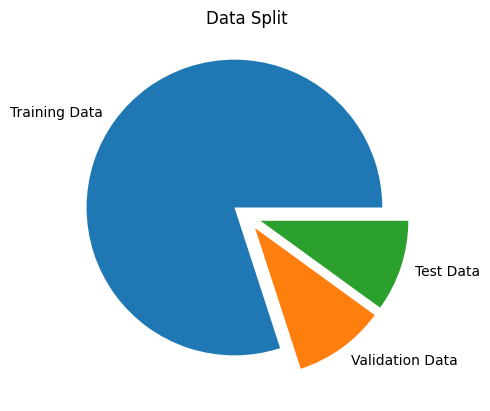

In [26]:
y = np.array([train_dataset.num_rows, val_dataset.num_rows, test_dataset.num_rows])
labels = ['Training Data', 'Validation Data', 'Test Data']
plt.pie(y, labels=labels, explode=[0.1,0.1,0.1])
plt.title("Data Split")
plt.show()

## Exploring the dataset

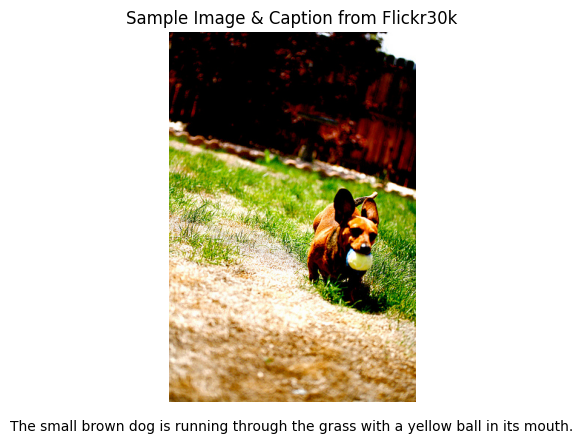

In [40]:
# Sample from the training set
sample = train_dataset[0]
image = sample["image"] 
caption = sample["caption"]

# Display Image
plt.imshow(image)
plt.axis("off")
plt.title('Sample Image & Caption from Flickr30k')
plt.text(0.5, -0.05, caption[0], ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

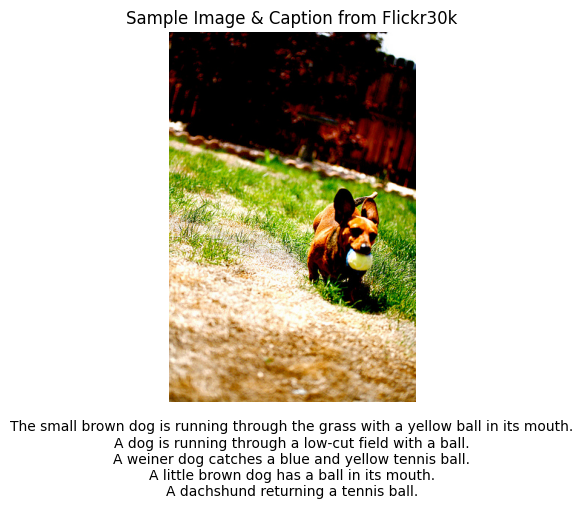

In [44]:
# Sample from the training set
sample = train_dataset[0]
image = sample["image"]
caption = sample["caption"]

# Display Image
plt.imshow(image)
plt.axis("off")
# Update to show all captions
plt.title('Sample Image & Caption from Flickr30k')
plt.text(0.5, -0.05, "\n".join(caption), ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

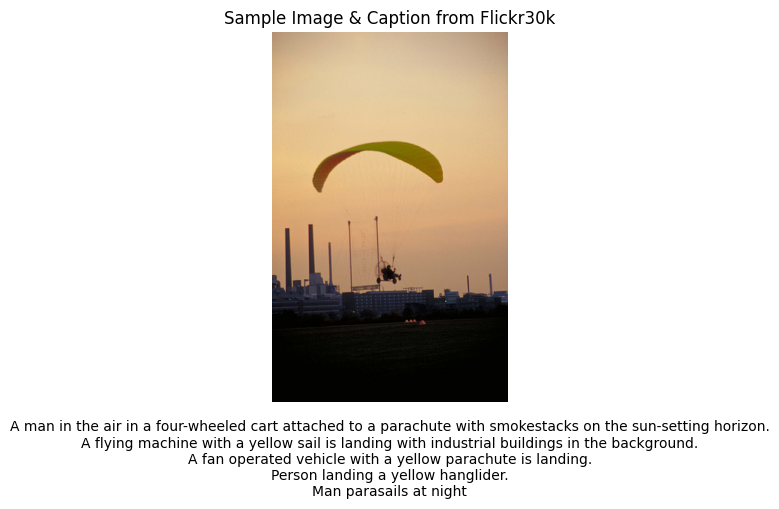

In [45]:
# Sample from the training set
sample = train_dataset[10]
image = sample["image"]
caption = sample["caption"]

# Display Image
plt.imshow(image)
plt.axis("off")
# Update to show all captions
plt.title('Sample Image & Caption from Flickr30k')
plt.text(0.5, -0.05, "\n".join(caption), ha='center', va='top', transform=plt.gca().transAxes)
plt.show()

### Dataset Characteristics

In [51]:
train_dataset.features

{'image': Image(mode=None, decode=True, id=None),
 'caption': [Value(dtype='string', id=None)],
 'sentids': [Value(dtype='string', id=None)],
 'img_id': Value(dtype='string', id=None),
 'filename': Value(dtype='string', id=None)}

In [53]:
train_dataset[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=333x500>,
 'caption': ['The small brown dog is running through the grass with a yellow ball in its mouth.',
  'A dog is running through a low-cut field with a ball.',
  'A weiner dog catches a blue and yellow tennis ball.',
  'A little brown dog has a ball in its mouth.',
  'A dachshund returning a tennis ball.'],
 'sentids': ['42790', '42791', '42792', '42793', '42794'],
 'img_id': '8558',
 'filename': '2800934095.jpg'}

We can see from the above that for our training process, we will only require the image and the captions.

### Preprocess Images

1. Resize
2. Normalize pixel values

### Tokenize Captions